In [36]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn

from pandas import Series, DataFrame
from pylab import rcParams
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report
from tableone import TableOne

%matplotlib inline
rcParams['figure.figsize'] = 10, 8
sb.set_style('whitegrid')

import warnings
warnings.filterwarnings('ignore')

In [37]:
L4_Q4 = pd.read_csv("alldbs.csv", sep=',', encoding='ISO-8859-1')

In [38]:
print("Entre todas las bases de datos tenemos:")
print("Tenemos "+ str(len(L4_Q4))+" pacientes con "+str(len(list(L4_Q4.columns)))+" variables." )

Entre todas las bases de datos tenemos:
Tenemos 4861 pacientes con 46 variables.


# Preparacion datasets.
***

- Elimino intermedios
- Elimino columnas no importantes

In [39]:

L4_Q4_2 = L4_Q4.drop(['patient_id','sis_q', 'lactate', 'lactate_offset','hospdis_status','icu_los','hosp_los'
                            ,'sis', 'psychiatric', 'fluid_electrolyte'
                            ], axis=1)

variables = list(['peripheral_vascular','hypertension','diabetes','hypothyroidism','renal_failure','liver_disease','metastatic_cancer','rheumatoid_arthritis','coagulopathy','obesity','deficiency_anemias','chronic_pulmonary_disease','solid_cancer','chronic_neurologic_diseases','substance_abuse','heart_diseases'])
for var in variables:
    L4_Q4_2[var] = np.where(L4_Q4_2[var]==1,'Yes','No')
    



In [40]:
print("High y normal tenemos:")
print("Tenemos "+ str(len(L4_Q4_2))+" pacientes con "+str(len(list(L4_Q4_2.columns)))+" variables." )


High y normal tenemos:
Tenemos 4861 pacientes con 36 variables.


# Tabla división databases

Tabla entre databases: 


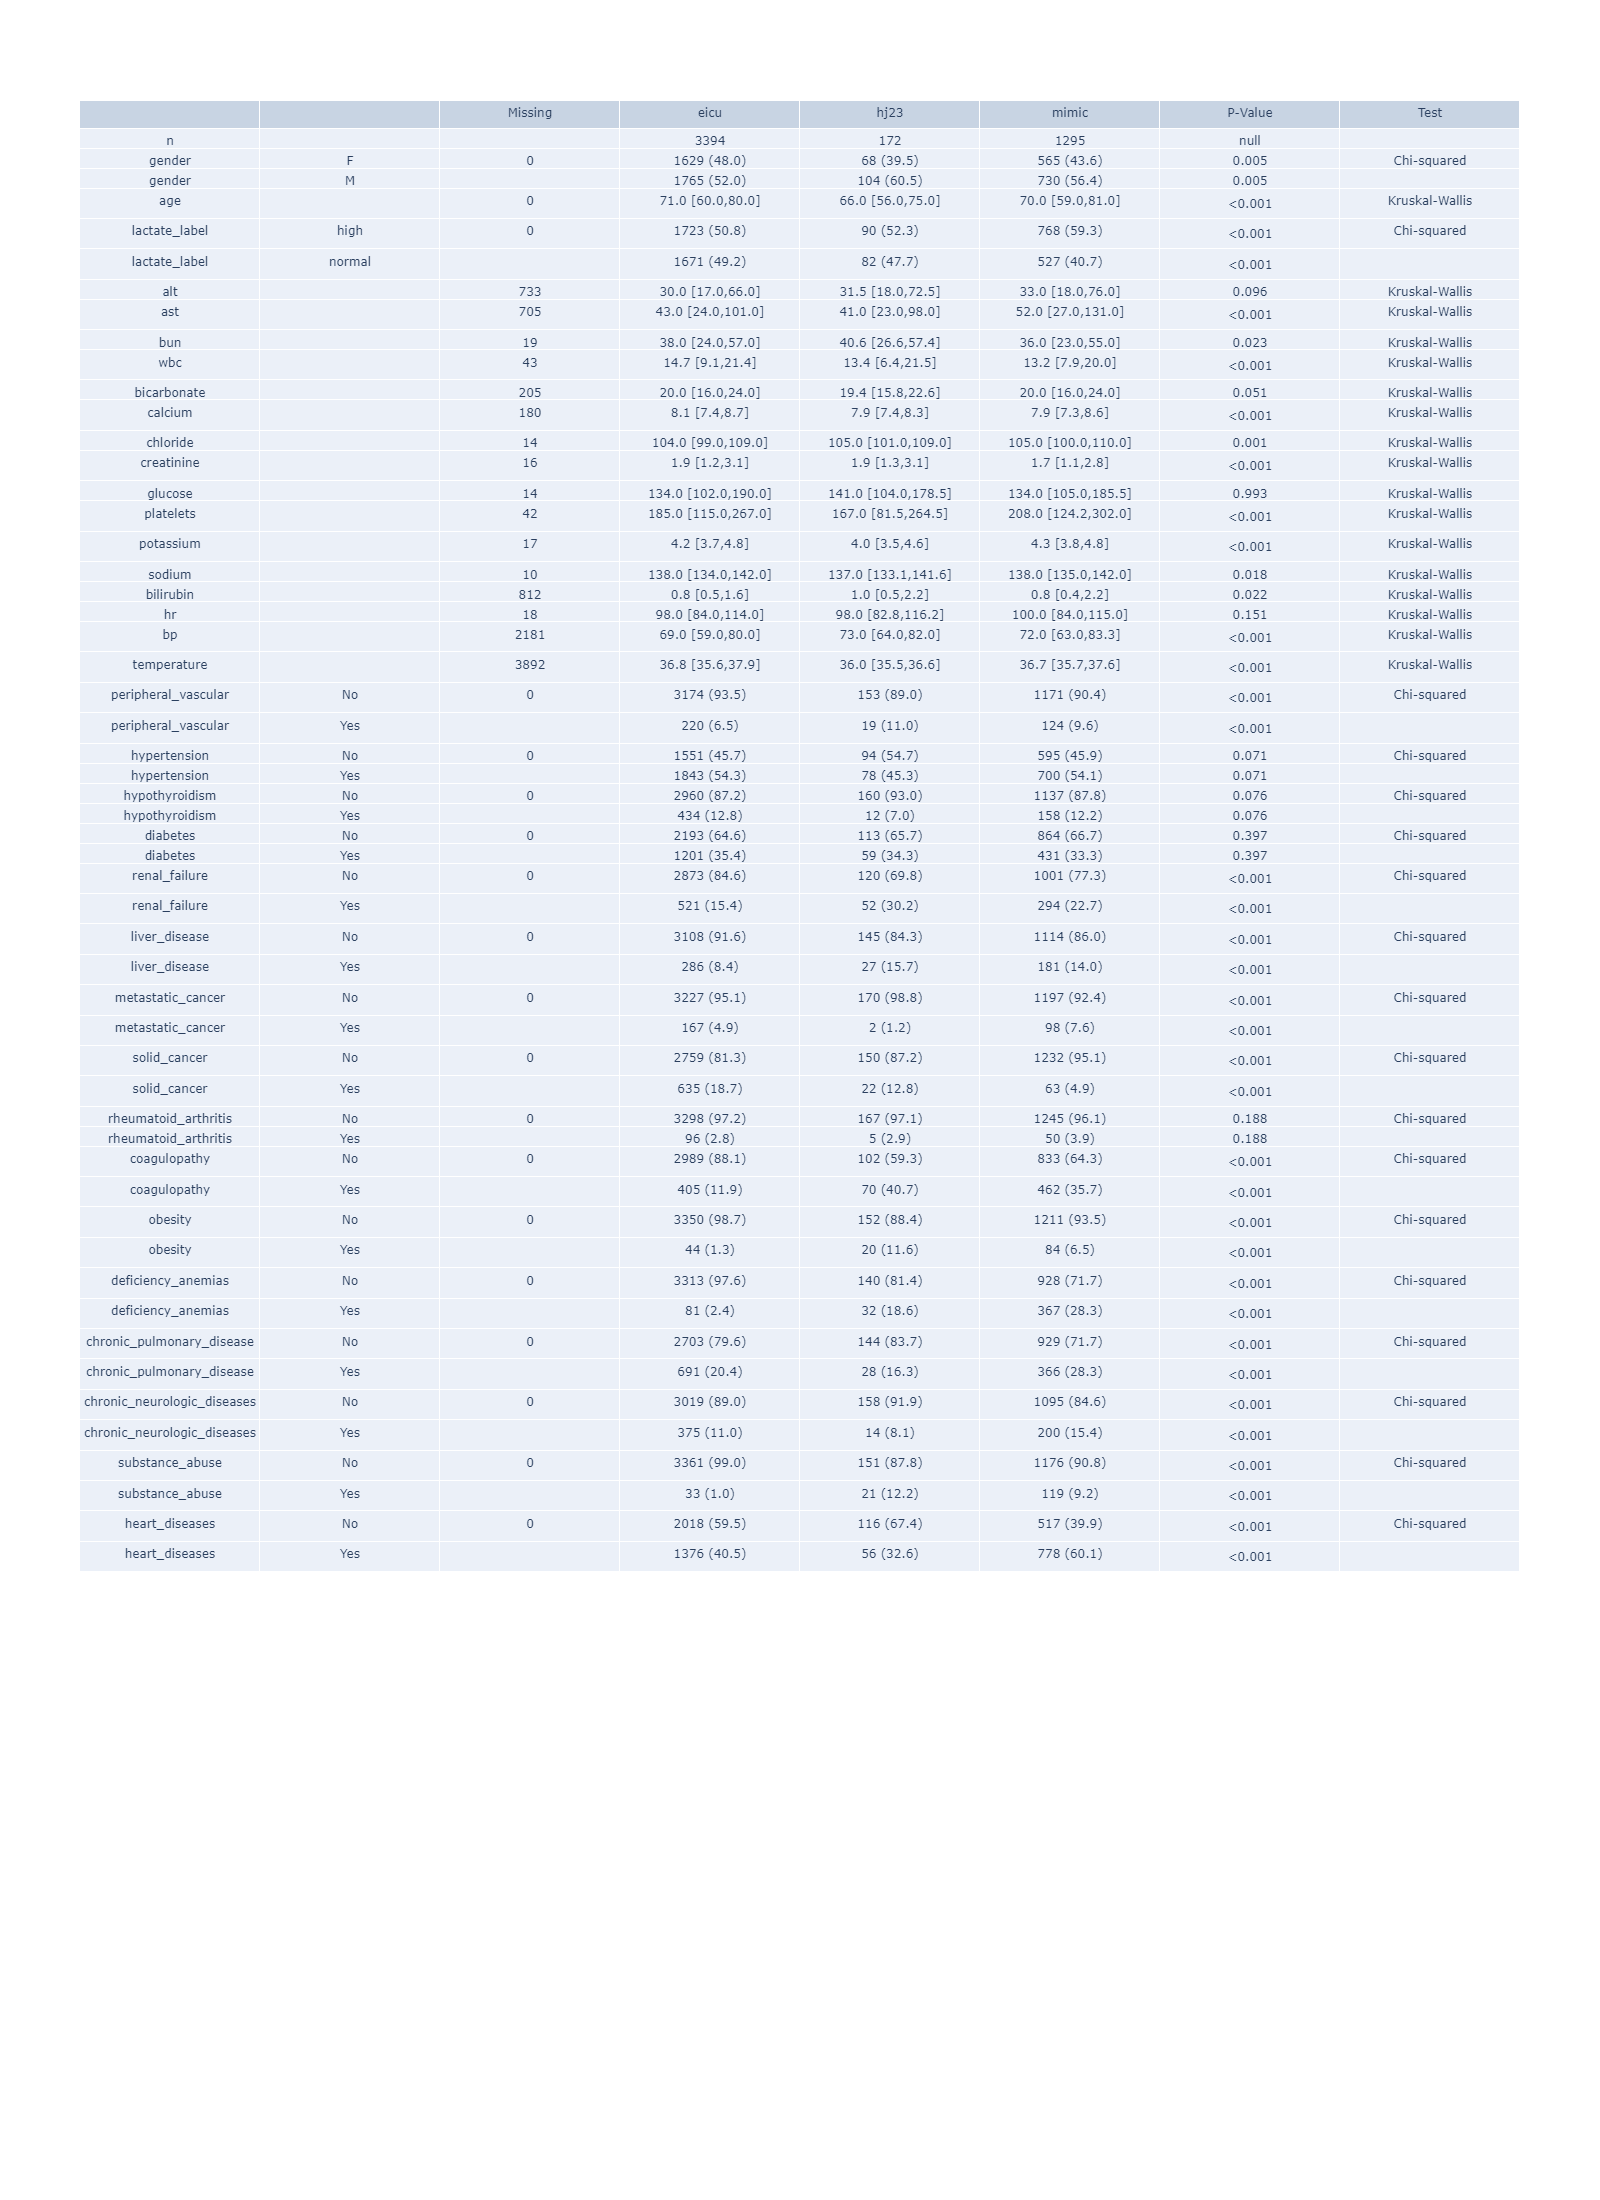

In [41]:
print("Tabla entre databases: ")
L4_Q4_2_db = L4_Q4_2.copy()


# TABLEONE para todo menos para ICU_LOS, IMV_d y VFD
# Divido las variables en categoricas y numéricas. 
categorical=list(L4_Q4_2_db.columns[L4_Q4_2_db.dtypes==np.object].drop('db'))
nonnormal=list(L4_Q4_2_db.columns[L4_Q4_2_db.dtypes!=np.object])

# Saco la tableone y formateo
tableOne=TableOne(L4_Q4_2_db, nonnormal=nonnormal,categorical=categorical,groupby=['db'], pval=True)
tableOne=tableOne.tableone.reset_index()
tableOne.columns = [col[0] if col[-1]=='' else col[-1] for col in tableOne.columns.values]
tableOne=tableOne.rename(columns={'level_0':'','level_1':' '})

tableOne.index= tableOne['']

# Elimino la columna de nulos porque no hay
# tableOne=tableOne.drop('Missing',axis=1)
tableOne['P-Value'] = np.where(tableOne['P-Value']=='',None,tableOne['P-Value'])
tableOne=tableOne.fillna(method='ffill')
# QuartilesScore=QuartilesScore.drop(columns={'Test'})

tableOne.to_csv('Tables/all_dbs.csv', sep=';', header = True, index=False)
# Ploteo la tabla
import plotly.graph_objects as go
fig = go.Figure(data=[go.Table(
    header=dict(values=list(tableOne.columns),
                align='center'),
    cells=dict(values=[tableOne[''],tableOne[' '],tableOne['Missing'],tableOne['eicu'],tableOne['hj23'],tableOne['mimic'],tableOne['P-Value'],tableOne['Test']],
               align='center'))
])
fig.update_layout(width=1600, height=2200)
fig.write_image("Tables/all_dbs.png")
figura=fig.to_image(format='png')
from IPython.display import Image
display(Image(figura))


- Divido en databases

In [42]:
mimic = L4_Q4_2[L4_Q4_2['db']=='mimic']
mimic = mimic.reset_index(drop=True)
mimic = mimic.drop('db', axis=1)


In [43]:
print("En mimic tenemos: ")
print("Tenemos "+ str(len(mimic))+" pacientes con "+str(len(list(mimic.columns)))+" variables." )


En mimic tenemos: 
Tenemos 1295 pacientes con 35 variables.


# Detección de nulos e imputación.
***
**Hay que hacerlo para las 3 icus**

- Empiezo por mimic.

In [44]:
# Creo un dataframe donde tengo las variables y el número de nulos de cada variable y los ordeno.
Nulos_mimic=pd.DataFrame(mimic.isnull().sum()).rename(columns={0:'Nulos'}).sort_values(by='Nulos',ascending=False)
# Calculo el porcentaje de nulos
Nulos_mimic['PorcentajeNulos'] = Nulos_mimic['Nulos']/len(mimic)

print(Nulos_mimic.loc[Nulos_mimic['PorcentajeNulos']>0])

# Elimino las variables que tienen un 50% de nulos
DeleteNulos=list(Nulos_mimic.loc[Nulos_mimic['PorcentajeNulos']>0.5].index)
DeleteNulos.remove('temperature')
mimic=mimic.drop(DeleteNulos, axis=1)

print("Voy a eliminar")
print(DeleteNulos)

#Muestro las dimensiones del nuevo dataframe
print("Tenemos "+ str(len(mimic))+" pacientes con "+str(len(list(mimic.columns)))+" variables." )






             Nulos  PorcentajeNulos
temperature   1135         0.876448
bilirubin      214         0.165251
alt            196         0.151351
ast            196         0.151351
calcium         18         0.013900
bicarbonate      3         0.002317
bun              1         0.000772
wbc              1         0.000772
creatinine       1         0.000772
platelets        1         0.000772
Voy a eliminar
[]
Tenemos 1295 pacientes con 35 variables.


In [45]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# IteraiveImputer es capaz de simular los resultados de mice de R. Multivariate Imputation by Chained Equations
# Para imputar cada valor utiliza solo las 10 variables más cercanas.
imp = IterativeImputer(max_iter=10, random_state=0,initial_strategy='median',n_nearest_features=20)

# Solo se pueden imputar las numericas, por eso se separan las variables
categorical=mimic[list(mimic.columns[mimic.dtypes==np.object])]
categorical['index']=categorical.index
numerical=mimic[list(mimic.columns[mimic.dtypes!=np.object])]
numerical['index']=numerical.index

# Imputamos las variables numericas
numerical_imputed=imp.fit_transform(numerical)
numerical_imputed=pd.DataFrame(numerical_imputed, columns=numerical.columns)

# Unimos todas las variables
mimic=pd.merge(numerical_imputed,categorical, on=['index'],how='left')
mimic=mimic.drop('index',axis=1)


# Estandarización de los datos.
***

Podemos usar StandardScaler -> Media 0, desviación 1. A diferencias de creencias, no convierte la variable a una distribución normal.  
Podemos usar MinMaxScaler -> Valores entre 0 y 1. 

In [46]:
from sklearn.preprocessing import StandardScaler 
sc_mimic = StandardScaler() 


mimic_no_std = mimic.copy()



# MIMIC
categorical=mimic[list(mimic.columns[mimic.dtypes==np.object])]
categorical['index']=categorical.index
numerical=mimic[list(mimic.columns[mimic.dtypes!=np.object])]

# Estandarizacion de las variables numericas
numerical_std=sc_mimic.fit_transform(numerical)  
numerical_std=pd.DataFrame(numerical_std, columns=numerical.columns)
numerical_std['index']=numerical_std.index

# Unimos todas las variables
mimic=pd.merge(numerical_std,categorical, on=['index'],how='left')
mimic=mimic.drop('index',axis=1)



# Test de colinealidad.
***
Buscamos la colinealidad con un heatmap. 
La buscamos tanto en cada una de las bases de datos como en la conjunta.

- MIMIC


--------------------------
Colinealidad Inicial Mimic


<AxesSubplot:>

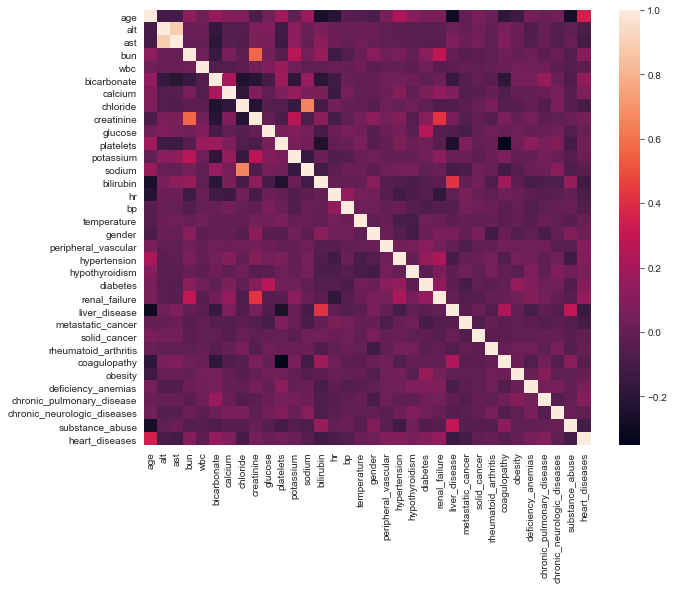

In [47]:
print("--------------------------")

print("Colinealidad Inicial Mimic")

# %matplotlib inline
rcParams['figure.figsize'] = 10, 8
sb.set_style('whitegrid')

mimic_col = mimic.copy()

from sklearn import preprocessing
categorical=mimic_col[list(mimic_col.columns[mimic_col.dtypes==np.object])]
categorical=categorical.drop(['lactate_label'],axis=1)
for col in categorical:
    mimic_col[col] = preprocessing.LabelEncoder().fit_transform(mimic_col[col])
    
mimic_col = mimic_col.drop('lactate_label',axis=1)
                                                                                 
sb.heatmap(mimic_col.corr())


In [48]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = [variance_inflation_factor(mimic_col.values, mimic_col.columns.get_loc(var)) for var in mimic_col.columns]
print(pd.Series(vif,index=mimic_col.columns))


age                            1.590194
alt                            4.926976
ast                            5.066990
bun                            1.699350
wbc                            1.064698
bicarbonate                    1.904316
calcium                        1.236776
chloride                       2.982355
creatinine                     2.042579
glucose                        1.210530
platelets                      1.347542
potassium                      1.260713
sodium                         2.615586
bilirubin                      1.427341
hr                             1.151391
bp                             1.064785
temperature                    1.037360
gender                         2.062960
peripheral_vascular            1.145995
hypertension                   2.160001
hypothyroidism                 1.201317
diabetes                       1.761592
renal_failure                  1.775715
liver_disease                  1.620885
metastatic_cancer              1.126718


Hay correlación ast/alt, y sodium/chloride. Solo algo importante ast/alt.

Elimino alt y chloride por su Variance Inflation Factor tienen. 

In [49]:
mimic = mimic.drop(['alt'], axis=1)
mimic_col = mimic_col.drop(['alt'], axis=1)
mimic_no_std = mimic_no_std.drop(['alt'], axis=1)


Colinealidad Final Mimic


<AxesSubplot:>

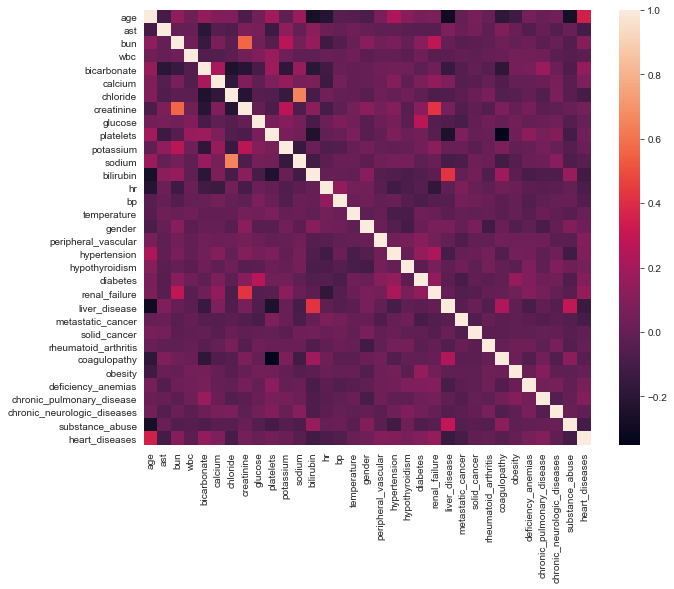

In [50]:
from sklearn import preprocessing
categorical=mimic_col[list(mimic_col.columns[mimic_col.dtypes==np.object])]
for col in categorical:
    mimic_col[col] = preprocessing.LabelEncoder().fit_transform(mimic_col[col])

print("Colinealidad Final Mimic")
                                                                                 
sb.heatmap(mimic_col.corr())


In [51]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

## First var "MaxTvVol"
vif = [variance_inflation_factor(mimic_col.values, mimic_col.columns.get_loc(var)) for var in mimic_col.columns]
print(pd.Series(vif,index=mimic_col.columns))



age                            1.582178
ast                            1.147747
bun                            1.698680
wbc                            1.064264
bicarbonate                    1.902405
calcium                        1.235995
chloride                       2.982306
creatinine                     2.042521
glucose                        1.205421
platelets                      1.347202
potassium                      1.260634
sodium                         2.615500
bilirubin                      1.423849
hr                             1.151088
bp                             1.064474
temperature                    1.037148
gender                         2.059403
peripheral_vascular            1.145934
hypertension                   2.159044
hypothyroidism                 1.201142
diabetes                       1.761153
renal_failure                  1.775691
liver_disease                  1.615504
metastatic_cancer              1.126689
solid_cancer                   1.078348


Vemos que todavía puede haber una pequeña correlación en creatinine/bun, pero ambas son muy bajas. 

In [52]:
# guardo los datasets

mimic_for_importants = mimic.copy()
mimic_for_importants_no_std = mimic_no_std.copy()




# Selección de variables.
***
Hago una TableOne y de aquí obtengo los P-Values, los tests utilizados son ambos no paramétricos.

- MIMIC

--------------------------
Table lactate Mimic


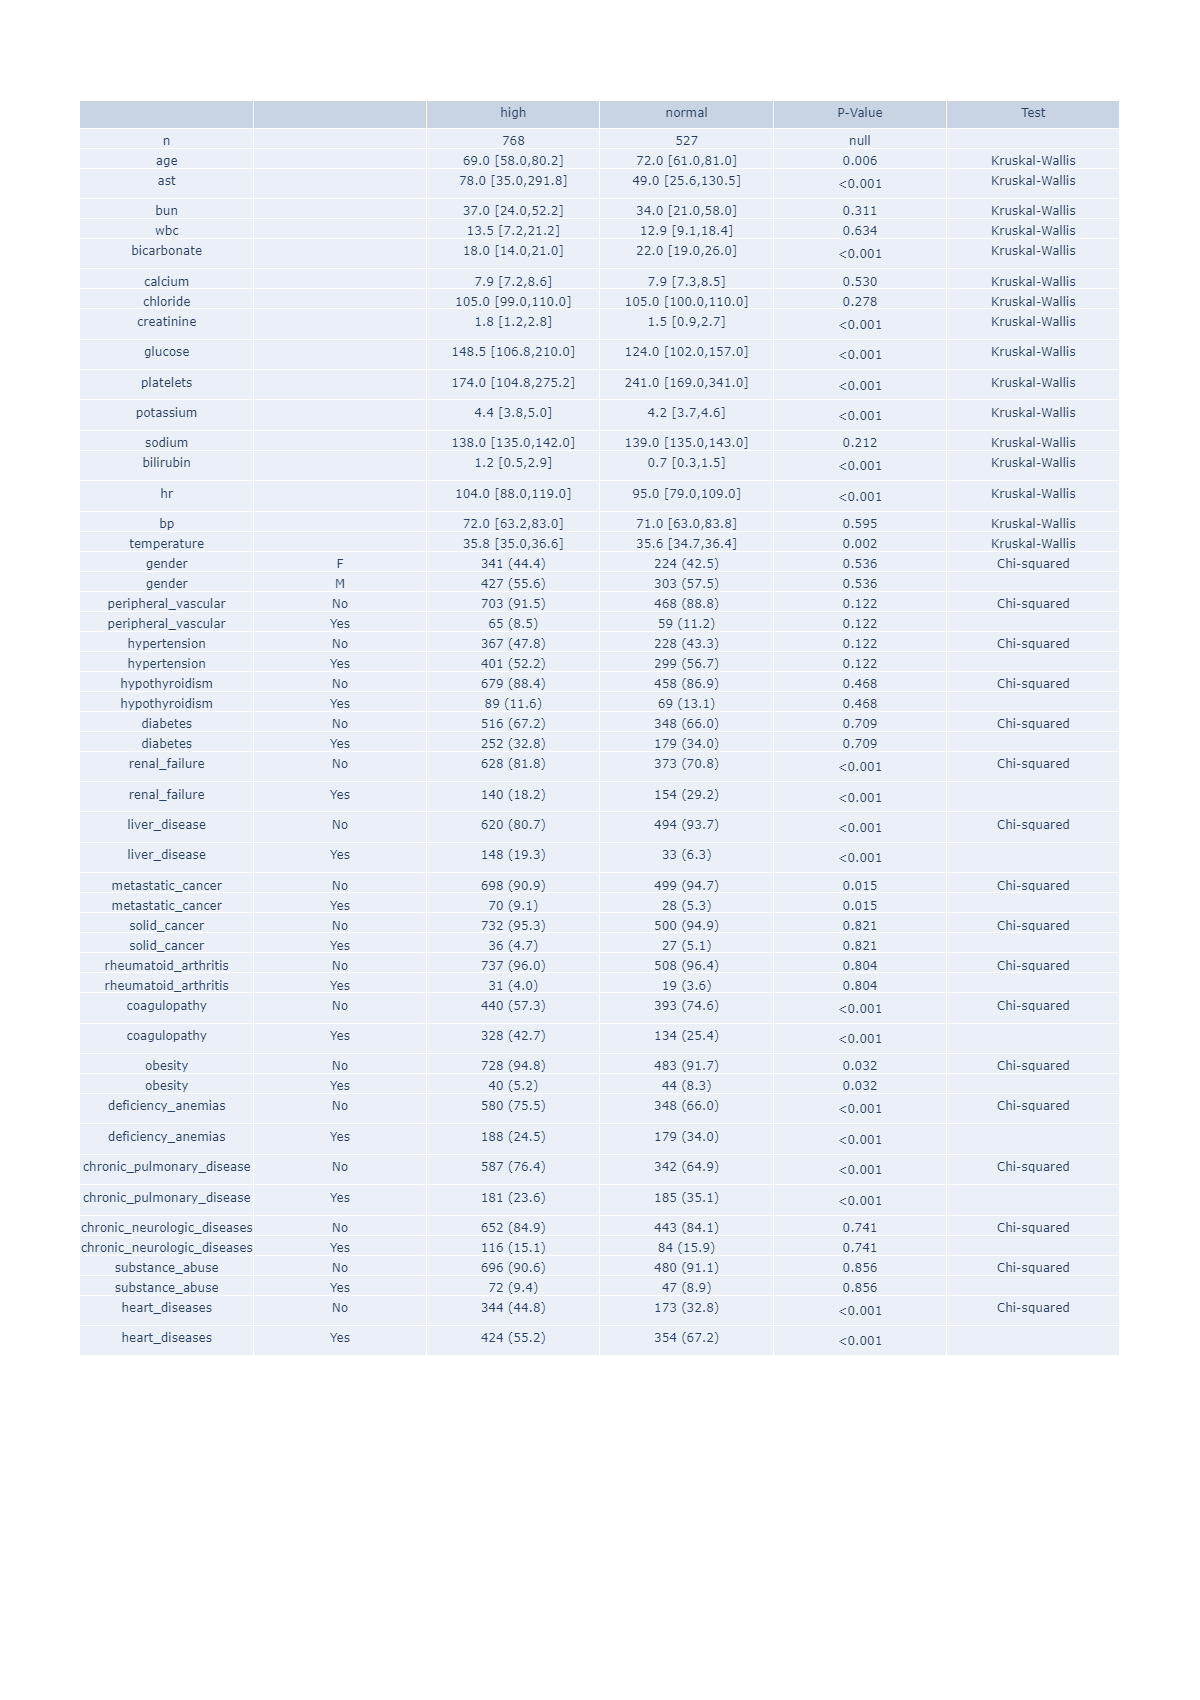

In [53]:
print("--------------------------")

print("Table lactate Mimic")
mimic_sel = mimic_no_std.copy()


# TABLEONE para todo menos para ICU_LOS, IMV_d y VFD
# Divido las variables en categoricas y numéricas. 
categorical=list(mimic_sel.columns[mimic_sel.dtypes==np.object].drop('lactate_label'))
nonnormal=list(mimic_sel.columns[mimic_sel.dtypes!=np.object])

# Saco la tableone y formateo
tableOne=TableOne(mimic_sel, nonnormal=nonnormal,categorical=categorical,groupby=['lactate_label'], pval=True)
tableOne=tableOne.tableone.reset_index()
tableOne.columns = [col[0] if col[-1]=='' else col[-1] for col in tableOne.columns.values]
tableOne=tableOne.rename(columns={'level_0':'','level_1':' '})

tableOne.index= tableOne['']

# Elimino la columna de nulos porque no hay
tableOne=tableOne.drop('Missing',axis=1)
tableOne['P-Value'] = np.where(tableOne['P-Value']=='',None,tableOne['P-Value'])
tableOne=tableOne.fillna(method='ffill')
# QuartilesScore=QuartilesScore.drop(columns={'Test'})

tableOne.to_csv('Tables/mimic_lactate.csv', sep=';', header = True, index=False)
# Ploteo la tabla
import plotly.graph_objects as go
fig = go.Figure(data=[go.Table(
    header=dict(values=list(tableOne.columns),
                align='center'),
    cells=dict(values=[tableOne[''],tableOne[' '],tableOne['high'],tableOne['normal'],tableOne['P-Value'],tableOne['Test']],
               align='center'))
])

fig.update_layout(width=1200, height=1700)
fig.write_image("Tables/mimic_table.png")
figura=fig.to_image(format='png')
from IPython.display import Image
display(Image(figura))


# Logistic Regression with CV
***

- MIMIC

In [54]:
print("--------------------------")

print("Logistic Regression at MIMIC for feature selection")

from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

feature_selector = SequentialFeatureSelector(LogisticRegression(solver='lbfgs'),
           k_features='best',
           scoring='roc_auc',
           forward=True,
           cv=5, n_jobs=-1)

mimic_lr = mimic.copy()
mimic_lr.to_csv('GeneratedFiles/Databases/mimic_lr.csv', sep=';', header = True, index=False)

mimic_lr['gender'] = np.where(mimic_lr['gender']=='M',1,0)

categorical=mimic_lr[list(mimic_lr.columns[mimic_lr.dtypes==np.object])].drop(['lactate_label'],axis=1)
for col in categorical:
    mimic_lr[col] = np.where(mimic_lr[col]=='Yes',1,0)
y = mimic_lr['lactate_label']
x= mimic_lr.drop(['lactate_label'],axis=1)
features = feature_selector.fit(np.array(x), y)


filtered_features= x.columns[list(features.k_feature_idx_)]
print("Selected features")
print(filtered_features)



--------------------------
Logistic Regression at MIMIC for feature selection
Selected features
Index(['age', 'ast', 'bun', 'wbc', 'bicarbonate', 'calcium', 'chloride',
       'creatinine', 'glucose', 'platelets', 'potassium', 'sodium',
       'bilirubin', 'hr', 'hypothyroidism', 'renal_failure', 'liver_disease',
       'metastatic_cancer', 'coagulopathy', 'deficiency_anemias',
       'chronic_pulmonary_disease', 'substance_abuse', 'heart_diseases'],
      dtype='object')


In [55]:
print(len(filtered_features))
print(features.k_score_)

23
0.8689351387591439


In [56]:

filtered_features=filtered_features.to_list()
filtered_features.append('lactate_label')

In [57]:
from sklearn.model_selection import cross_validate
mimic_lr = mimic.copy()

mimic_lr = mimic_lr[filtered_features]
mimic_lr_2 = mimic_lr.copy()

if 'gender' in filtered_features:
    mimic_lr['gender'] = np.where(mimic_lr['gender']=='M',1,0)

categorical=mimic_lr[list(mimic_lr.columns[mimic_lr.dtypes==np.object])].drop(['lactate_label'],axis=1)
for col in categorical:
    mimic_lr[col] = np.where(mimic_lr[col]=='Yes',1,0)

mimic_lr['lactate_label'] = np.where(mimic_lr['lactate_label'] == 'high',1,0)

lr = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
y_lr = mimic_lr['lactate_label']
x_lr= mimic_lr.drop(['lactate_label'],axis=1)

cv_model = cross_validate(lr, x_lr, y_lr, cv=5, return_train_score=True, return_estimator=True, scoring = ['accuracy', 'recall', 'roc_auc'])
scores=pd.DataFrame(cv_model['test_accuracy'])
scores.columns=['score']
scores = scores.sort_values('score',ascending=False)
print("Scores of Cross Validation")
print(scores)

best_estimator = cv_model['estimator'][scores.iloc[0].name]

print('roc '+str(cv_model['test_roc_auc'][scores.iloc[0].name]))
print('recall '+str(cv_model['test_recall'][scores.iloc[0].name]))

Scores of Cross Validation
      score
3  0.829457
2  0.795367
4  0.782946
0  0.780769
1  0.746154
roc 0.8965452847805788
recall 0.8888888888888888


Importance of features for MIMIC after CV


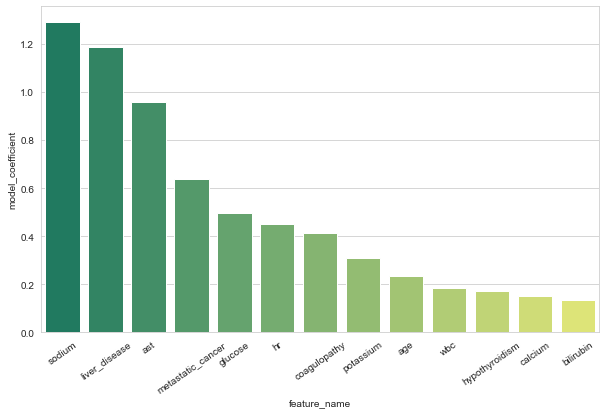

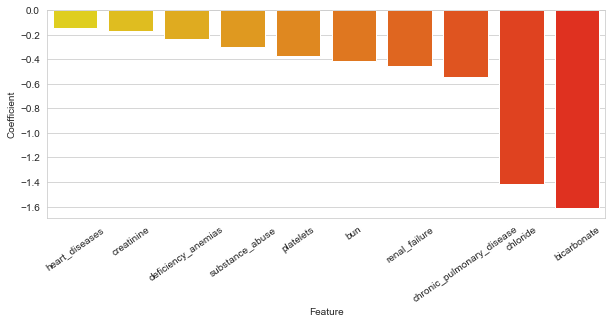

In [58]:
print("Importance of features for MIMIC after CV") 
# Get the models coefficients (and top 5 and bottom 5)
logReg_coeff_lr_mimic = pd.DataFrame({'feature_name': x_lr.columns.values, 'model_coefficient': best_estimator.coef_.transpose().flatten()})
logReg_coeff_lr_mimic = logReg_coeff_lr_mimic.sort_values('model_coefficient',ascending=False)
logReg_coeff_top = logReg_coeff_lr_mimic.head(sum(logReg_coeff_lr_mimic['model_coefficient']>0))
logReg_coeff_bottom = logReg_coeff_lr_mimic.tail(sum(logReg_coeff_lr_mimic['model_coefficient']<0))


# Plot top 5 coefficients
plt.figure().set_size_inches(10, 6)
fg3 = sb.barplot(x='feature_name', y='model_coefficient',data=logReg_coeff_top, palette="summer")
fg3.set_xticklabels(rotation=35, labels=logReg_coeff_top.feature_name)
# Plot bottom 5 coefficients
plt.figure().set_size_inches(10,6)
fg4 = sb.barplot(x='feature_name', y='model_coefficient',data=logReg_coeff_bottom, palette="autumn_r")
fg4.set_xticklabels(rotation=35, labels=logReg_coeff_bottom.feature_name)
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.subplots_adjust(bottom=0.4)
# plt.savefig('figure_4.png')

In [59]:
print("Classification")

from sklearn import metrics
pred=best_estimator.predict(x_lr)
classes_lr=np.where(np.logical_and(pred==1,y_lr.values==1),'TP',
         np.where(np.logical_and(pred==1,y_lr.values==0),'FP',
                  np.where(np.logical_and(pred==0,y_lr.values==0), 'TN',
                           np.where(np.logical_and(pred==0,y_lr.values==1),'FN','MAL'))))
import scipy
print(scipy.stats.itemfreq(classes_lr))


Classification
[['FN' '128']
 ['FP' '143']
 ['TN' '384']
 ['TP' '640']]


In [60]:
logReg_coeff_lr_mimic.to_csv('GeneratedFiles/ImportantVariables/coef_lr_mimic.csv', sep=';', header = False, index=False)

# RandomForest with CV
***

- MIMIC

In [61]:
print("--------------------------")

print("Random Forest at MIMIC for feature selection")

feature_selector = SequentialFeatureSelector(RandomForestClassifier(n_estimators=200, random_state=0,max_depth=10, n_jobs=-1),
           k_features='best',
           scoring='roc_auc',
           forward=True,
           cv=5, n_jobs=-1)

mimic_rf = mimic_no_std.copy()
mimic_rf_2 = mimic_rf.copy()
mimic_rf_2.to_csv('GeneratedFiles/Databases/mimic_rf.csv', sep=';', header = True, index=False)

mimic_rf_2['gender'] = np.where(mimic_rf_2['gender']=='M',1,0)

categorical=mimic_rf_2[list(mimic_rf_2.columns[mimic_rf_2.dtypes==np.object])].drop(['lactate_label'],axis=1)
for col in categorical:
    mimic_rf_2[col] = np.where(mimic_rf_2[col]=='Yes',1,0)
y = mimic_rf_2['lactate_label']
x= mimic_rf_2.drop(['lactate_label'],axis=1)
features = feature_selector.fit(np.array(x), y)


filtered_features= x.columns[list(features.k_feature_idx_)]
print("Selected Features")
print(filtered_features)


--------------------------
Random Forest at MIMIC for feature selection
Selected Features
Index(['ast', 'bun', 'wbc', 'bicarbonate', 'calcium', 'chloride', 'creatinine',
       'glucose', 'platelets', 'sodium', 'bilirubin', 'hr',
       'peripheral_vascular', 'hypertension', 'diabetes', 'renal_failure',
       'liver_disease', 'metastatic_cancer', 'solid_cancer', 'obesity',
       'deficiency_anemias', 'chronic_pulmonary_disease'],
      dtype='object')


In [62]:
print(len(filtered_features))
print(features.k_score_)

22
0.8509467808468919


In [63]:

filtered_features=filtered_features.to_list()
filtered_features.append('lactate_label')

Score for CV
      score
3  0.810078
0  0.796154
4  0.775194
2  0.764479
1  0.742308
roc 0.8763772175536881
recall 0.8758169934640523


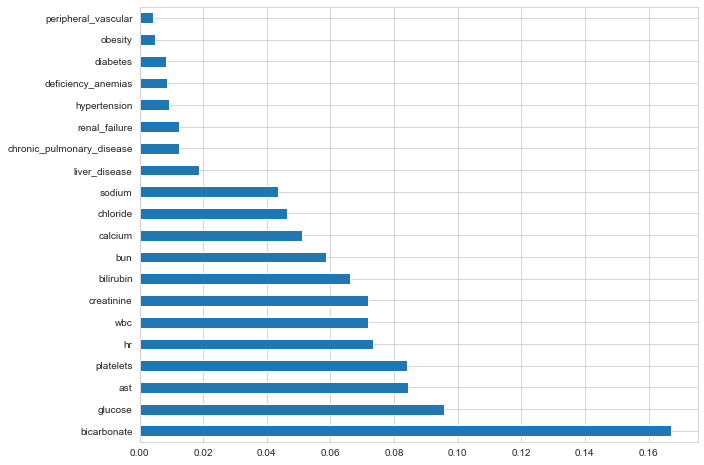

In [64]:
from sklearn.model_selection import cross_validate
mimic_rf_2 = mimic_rf.copy()

mimic_rf_2 = mimic_rf_2[filtered_features]

if 'gender' in filtered_features:
    mimic_rf_2['gender'] = np.where(mimic_rf_2['gender']=='M',1,0)
    
categorical=mimic_rf_2[list(mimic_rf_2.columns[mimic_rf_2.dtypes==np.object])].drop(['lactate_label'],axis=1)
for col in categorical:
    mimic_rf_2[col] = np.where(mimic_rf_2[col]=='Yes',1,0)

mimic_rf_2['lactate_label'] = np.where(mimic_rf_2['lactate_label'] == 'high',1,0)

rf = features.estimator
y_rf = mimic_rf_2['lactate_label']
x_rf= mimic_rf_2.drop(['lactate_label'],axis=1)


cv_model = cross_validate(rf, x_rf, y_rf, cv=5, return_train_score=True, return_estimator=True, scoring = ['accuracy', 'recall', 'roc_auc'])
scores=pd.DataFrame(cv_model['test_accuracy'])
scores.columns=['score']
scores = scores.sort_values('score',ascending=False)
print("Score for CV")
print(scores)

bestRF = cv_model['estimator'][scores.iloc[0].name]
plt.figure(103)
importances = pd.Series(bestRF.feature_importances_,x_rf.columns)
importances.nlargest(20).plot(kind='barh')

print('roc '+str(cv_model['test_roc_auc'][scores.iloc[0].name]))
print('recall '+str(cv_model['test_recall'][scores.iloc[0].name]))


In [65]:
for var in importances.index:
    if var in list(categorical.columns):
        high = sum(mimic_rf_2.loc[mimic_rf_2['lactate_label']==1][var] == 1)
        low = sum(mimic_rf_2.loc[mimic_rf_2['lactate_label']==0][var] == 1)
        if(high<=low):
            importances[var] = -importances[var]
    else:
        high = np.median(mimic_rf_2.loc[mimic_rf_2['lactate_label']==1][var])
        low = np.median(mimic_rf_2.loc[mimic_rf_2['lactate_label']==0][var])
        if(high<=low):
            importances[var] = -importances[var]

Importance of features for MIMIC after CV


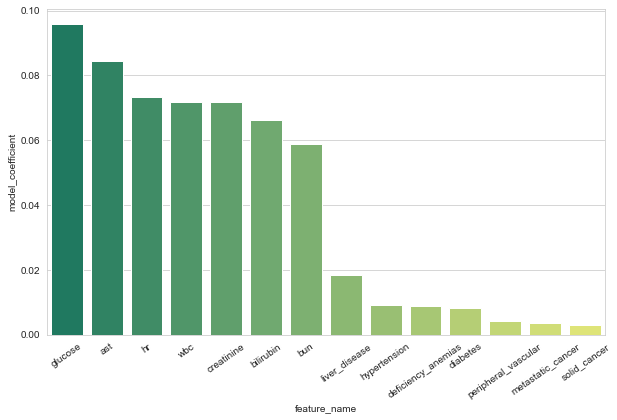

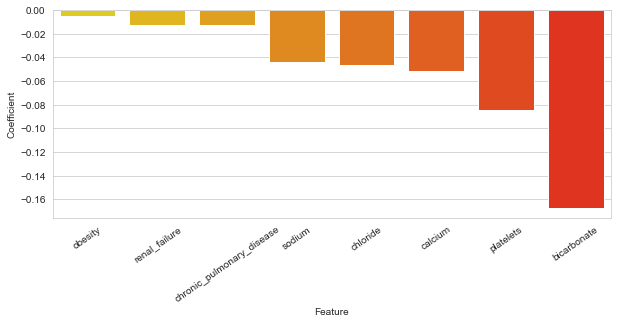

In [66]:
print("Importance of features for MIMIC after CV") 
    
# Get the models coefficients (and top 5 and bottom 5)
logReg_coeff_rf_mimic = pd.DataFrame({'feature_name': x_rf.columns.values, 'model_coefficient': importances})
logReg_coeff_rf_mimic = logReg_coeff_rf_mimic.sort_values('model_coefficient',ascending=False)
logReg_coeff_top = logReg_coeff_rf_mimic.head(sum(logReg_coeff_rf_mimic['model_coefficient']>0))
logReg_coeff_bottom = logReg_coeff_rf_mimic.tail(sum(logReg_coeff_rf_mimic['model_coefficient']<0))


# Plot top 5 coefficients
plt.figure(100).set_size_inches(10, 6)
fg3 = sb.barplot(x='feature_name', y='model_coefficient',data=logReg_coeff_top, palette="summer")
fg3.set_xticklabels(rotation=35, labels=logReg_coeff_top.feature_name)
# Plot bottom 5 coefficients
plt.figure(101).set_size_inches(10,6)
fg4 = sb.barplot(x='feature_name', y='model_coefficient',data=logReg_coeff_bottom, palette="autumn_r")
fg4.set_xticklabels(rotation=35, labels=logReg_coeff_bottom.feature_name)
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.subplots_adjust(bottom=0.4)
# plt.savefig('figure_4.png')

In [67]:
print("Classification")
from sklearn import metrics
pred=bestRF.predict(x_rf)
classes_rf=np.where(np.logical_and(pred==1,y_rf.values==1),'TP',
         np.where(np.logical_and(pred==1,y_rf.values==0),'FP',
                  np.where(np.logical_and(pred==0,y_rf.values==0), 'TN',
                           np.where(np.logical_and(pred==0,y_rf.values==1),'FN','MAL'))))
import scipy
print(scipy.stats.itemfreq(classes_rf))


Classification
[['FN' '31']
 ['FP' '36']
 ['TN' '491']
 ['TP' '737']]


In [68]:
logReg_coeff_rf_mimic.to_csv('GeneratedFiles/ImportantVariables/coef_rf_mimic.csv', sep=';', header = False, index=False)


# ORTHOGONAL PLS

In [69]:
print("--------------------------")

print("Orthogonal PLS at MIMIC for feature selection")

mimic_pls=mimic.copy()
mimic_pls.to_csv('GeneratedFiles/Databases/mimic_pls.csv', sep=';', header = True, index=False)
mimic_pls['gender'] = np.where(mimic_pls['gender']=='M',1,0)
categorical=mimic_pls[list(mimic_pls.columns[mimic_pls.dtypes==np.object])].drop(['lactate_label'],axis=1)
for col in categorical:
    mimic_pls[col] = np.where(mimic_pls[col]=='Yes',1,0)

mimic_pls['lactate_label'] = np.where(mimic_pls['lactate_label'] == 'high',1,0)

y_lr = mimic_pls['lactate_label']
x_lr= mimic_pls.drop(['lactate_label'],axis=1)


# x_lr=x_lr.drop('classes', axis=1)
y_lr = np.array(y_lr, dtype=int)

--------------------------
Orthogonal PLS at MIMIC for feature selection


In [70]:
import itertools
from sklearn.model_selection import KFold
from pyopls import OPLS
from sklearn.cross_decomposition import PLSCanonical, PLSRegression, CCA
from sklearn import metrics

def primeros_tres_pls():
    combinatoria= list(itertools.combinations(list(x_lr.columns),3))
    mejor_media = 0 
    for i in combinatoria: 
        actual = list()
        for var in i: 
            actual.append(var)
        x_pls = pd.DataFrame(x_lr[actual])
        kf = KFold(n_splits=5)
        roc_pls_componentes=list()
        for train_index, test_index in kf.split(mimic):
            X_train = x_pls.iloc[train_index]
            X_test = x_pls.iloc[test_index]
            y_train, y_test = y_lr[train_index], y_lr[test_index]
            opls = OPLS(2,scale=False)
            Z = opls.fit(X_train, y_train)
            X_train=X_train.astype(np.float64)
            Z_trans= Z.transform(X_train)
            pls2 = PLSRegression(1,scale=False)
            pls2.fit(Z_trans, y_train)
            X_test=X_test.astype(np.float64)
            Z_trans_test = Z.transform(X_test)
            predict=pls2.predict(Z_trans_test)
            predict_roc=np.where(predict>1,1,np.where(predict<0,0,predict))
            roc_pls_componentes.append(metrics.roc_auc_score(y_test,predict_roc))
        roc_pls_componentes.sort(reverse=True)
#         media_acc = roc_pls_componentes[0]
        media_acc = sum(roc_pls_componentes)/5
        if media_acc>mejor_media: 
            mejor_media = media_acc
            selected = actual
    return(mejor_media, selected)

In [71]:
from sklearn.model_selection import KFold
from pyopls import OPLS
from sklearn.cross_decomposition import PLSCanonical, PLSRegression, CCA
from sklearn import metrics

def busca_nueva(dataset,objetivo, media_actual, seleccionadas):
    lista_vars = list(dataset.columns)
    lista_vars=[ele for ele in lista_vars if ele not in selected] 
    mejor_media=media_actual
    mejor_var = ''
    for i in (lista_vars):
        selected.append(i)
        x_pls = pd.DataFrame(dataset[selected])
        kf = KFold(n_splits=5)
        roc_pls_componentes=list()
        for train_index, test_index in kf.split(mimic):
            X_train = x_pls.iloc[train_index]
            X_test = x_pls.iloc[test_index]
            y_train, y_test = objetivo[train_index], objetivo[test_index]
            if(len(X_train.columns)==3):
                opls = OPLS(2,scale=False)
            else: 
                opls = OPLS(3,scale=False)
            Z = opls.fit(X_train, y_train)
            X_train=X_train.astype(np.float64)
            Z_trans= Z.transform(X_train)
            pls2 = PLSRegression(1,scale=False)
            pls2.fit(Z_trans, y_train)
            Z_trans_test = Z.transform(X_test)
            predict=pls2.predict(Z_trans_test)
            predict_roc=np.where(predict>1,1,np.where(predict<0,0,predict))
            roc_pls_componentes.append(metrics.roc_auc_score(y_test,predict_roc))
        roc_pls_componentes.sort(reverse=True)
#         media_acc = roc_pls_componentes[0]
        media_acc = sum(roc_pls_componentes)/5
        if media_acc>=mejor_media: 
            mejor_media = media_acc
            mejor_var = i
        selected.remove(i)
#     print("Accuracy media ",str(mejor_media) )
#     print(mejor_var)
    return(mejor_media,mejor_var)
    

media, selected=primeros_tres_pls()
print(media, selected)
trobat = False
while (not(trobat)):
    media_acc,mejor_var=busca_nueva(x_lr,y_lr, media, selected)
    print(media_acc,mejor_var)
    if(mejor_var==''):
        trobat=True
    else: 
        media = media_acc
        selected.append(mejor_var)
    
print("Selected Features")
print(selected)
    





0.7980558119496483 ['bicarbonate', 'chloride', 'sodium']
0.8157405867254072 creatinine
0.8254967891993197 glucose
0.8341831160827354 platelets
0.8433275416285634 hr
0.8472202327251331 liver_disease
0.849957563664552 potassium
0.8524298646859293 bun
0.8544890137134533 chronic_pulmonary_disease
0.8557405060331611 metastatic_cancer
0.8567683007532612 renal_failure
0.8569866709596725 substance_abuse
0.8570224841325171 rheumatoid_arthritis
0.8570224841325171 
Selected Features
['bicarbonate', 'chloride', 'sodium', 'creatinine', 'glucose', 'platelets', 'hr', 'liver_disease', 'potassium', 'bun', 'chronic_pulmonary_disease', 'metastatic_cancer', 'renal_failure', 'substance_abuse', 'rheumatoid_arthritis']


In [72]:
x_pls = x_lr[selected]
kf = KFold(n_splits=5)
accuracy_pls_componentes=list()
roc_pls_componentes=list()
coefs_componentes = list()
recall_componentes = list()
for train_index, test_index in kf.split(mimic):
    X_train = x_pls.iloc[train_index]
    X_test = x_pls.iloc[test_index]
    y_train, y_test = y_lr[train_index], y_lr[test_index]
    opls = OPLS(3,scale=False)
    Z = opls.fit(X_train, y_train)
    Z_trans= Z.transform(X_train)
    pls2 = PLSRegression(1,scale=False)
    pls2.fit(Z_trans, y_train)
    Z_trans_test = Z.transform(X_test)
    predict=pls2.predict(Z_trans_test)
    predict_auc=np.where(predict>=0.5,1,0)
    predict_roc=np.where(predict>1,1,np.where(predict<0,0,predict))
    accuracy_pls_componentes.append(metrics.accuracy_score(y_test,predict_auc))
    roc_pls_componentes.append(metrics.roc_auc_score(y_test,predict_roc))
    recall_componentes.append(metrics.recall_score(y_test,predict_auc))
    coefs_componentes.append(pls2.coef_)
# print(accuracy_pls_componentes)
# print(roc_pls_componentes)


scores=pd.DataFrame(accuracy_pls_componentes)
scores.columns=['score']
scores = scores.sort_values('score',ascending=False)
print("Score for CV")
print(scores)


print('roc '+str(roc_pls_componentes[scores.iloc[0].name]))
print('recall '+str(recall_componentes[scores.iloc[0].name]))

Score for CV
      score
0  0.799228
4  0.795367
3  0.779923
2  0.756757
1  0.752896
roc 0.876993620414673
recall 0.8421052631578947


Importance of features for MIMIC after CV


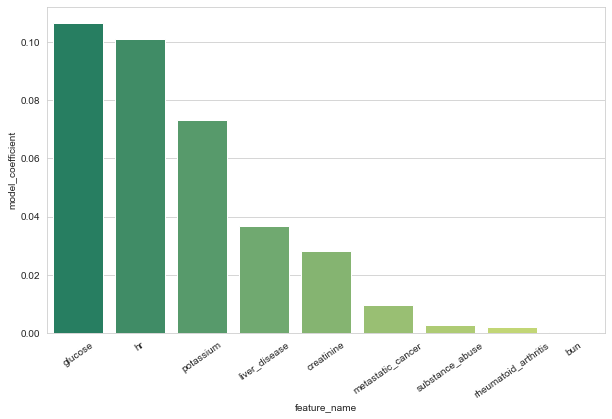

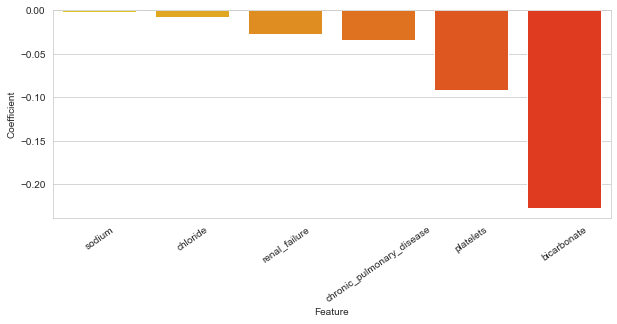

In [73]:
print("Importance of features for MIMIC after CV") 
feature_importances_ = coefs_componentes[scores.iloc[0].name]
# Get the models coefficients (and top 5 and bottom 5)
logReg_coeff_pls_mimic = pd.DataFrame({'feature_name': x_pls.columns.values, 'model_coefficient': feature_importances_.transpose().flatten()})
logReg_coeff_pls_mimic = logReg_coeff_pls_mimic.sort_values('model_coefficient',ascending=False)
logReg_coeff_top = logReg_coeff_pls_mimic.head(sum(logReg_coeff_pls_mimic['model_coefficient']>0))
logReg_coeff_bottom = logReg_coeff_pls_mimic.tail(sum(logReg_coeff_pls_mimic['model_coefficient']<0))


# Plot top 5 coefficients
plt.figure().set_size_inches(10, 6)
fg3 = sb.barplot(x='feature_name', y='model_coefficient',data=logReg_coeff_top, palette="summer")
fg3.set_xticklabels(rotation=35, labels=logReg_coeff_top.feature_name)
# Plot bottom 5 coefficients
plt.figure().set_size_inches(10,6)
fg4 = sb.barplot(x='feature_name', y='model_coefficient',data=logReg_coeff_bottom, palette="autumn_r")
fg4.set_xticklabels(rotation=35, labels=logReg_coeff_bottom.feature_name)
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.subplots_adjust(bottom=0.4)
# plt.savefig('figure_4.png')

In [74]:
logReg_coeff_pls_mimic.to_csv('GeneratedFiles/ImportantVariables/coef_pls_mimic.csv', sep=';', header = False, index=False)